In [11]:
pwd

'Z:\\proj\\pub_info'

**다른 패키지 로딩 후 Okt 로딩하면 okt = Okt() 가 잘 안됨!!!!**  
==> 그래서 okt = Okt() 젤먼저

In [12]:
from konlpy.tag import Okt

In [13]:
okt = Okt()

In [14]:
from navsch import *

In [15]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [16]:
import gc
gc.collect()

96349

In [7]:
begm = ['2003.04.01','2008.10.01','2008.11.01','2015.10.01']
endm = ['2003.04.30','2008.10.31','2008.11.30','2015.10.31']

1.data crawling

In [8]:
%%time
dfs = []
for beg, end in zip(begm,endm):
    dfs.append(naver_search_d('가계부채',beg,end,pages=5))
    
df = pd.concat(dfs,axis=0)   
df.to_pickle('data/d2vdf.pkl')

가계부채 2003 search done, 00:01:33 elapsed
가계부채 2008 search done, 00:01:43 elapsed
가계부채 2008 search done, 00:01:53 elapsed
가계부채 2015 search done, 00:02:02 elapsed
Wall time: 7min 14s


In [17]:
df = pd.read_pickle('data/d2vdf.pkl')

2.preprocess

In [9]:
data = [t.replace('\n','') for t in df.text if t!='']

3.tokenize

In [10]:
tag_d1 = [TaggedDocument(words=okt.nouns(d), tags=[str(i)]) for i, d in enumerate(data)]
tag_d2 = [TaggedDocument(words=okt.morphs(d), tags=[str(i)]) for i, d in enumerate(data)]

In [11]:
tag_d3 = [TaggedDocument(words='/'.join(t), tags=[str(i)]) for d in data for i,t in enumerate(okt.pos(d))]

3.1 tokenize review

In [18]:
tok_n = lambda doc: okt.nouns(doc)
tok_m = lambda doc: okt.morphs(doc)
tok_p = lambda doc: ['/'.join(t) for t in okt.pos(doc)] # okt.pos(doc): (사스, Noun), 이거 사스/Noun

In [19]:
df['token_review_n'] = df.text.apply(tok_n)
df['token_review_m'] = df.text.apply(tok_m)
df['token_review_p'] = df.text.apply(tok_p)

4.doc2vec에 토큰을 load

In [14]:
model1 = Doc2Vec(vector_size = 50,
               alpha = 0.25,
               min_alpha = 0.00025,
               min_count = 1,
               dm = 1)
model1.build_vocab(tag_d1)

In [15]:
model2 = Doc2Vec(vector_size = 50,
               alpha = 0.25,
               min_alpha = 0.00025,
               min_count = 1,
               dm = 1)
model2.build_vocab(tag_d2)

In [16]:
model3 = Doc2Vec(vector_size = 50,
               alpha = 0.25,
               min_alpha = 0.00025,
               min_count = 1,
               dm = 1)
model3.build_vocab(tag_d3)

5.model fitting

import logging
logging.basicConfig(format = '%(asctime)s : %(levelname)s : %(message)s',level = logging.INFO)

In [17]:
%%time
for epoch in range(10):
    print('iteration {}'.format(epoch))
    model3.train(tag_d3,
               total_examples = model3.corpus_count,
               epochs = model3.epochs)
    model3.alpha -=0.0002 # 학습률을 감소시킨다
    model3.min_alpha = model3.alpha

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
Wall time: 6min 2s


In [18]:
model3.save('nav_mod3.model')

In [20]:
model3 = Doc2Vec.load('nav_mod3.model')

In [24]:
%%time
for epoch in range(10):
    print('iteration {}'.format(epoch))
    model1.train(tag_d1,
               total_examples = model1.corpus_count,
               epochs = model1.epochs)
    model1.alpha -=0.0002 # 학습률을 감소시킨다
    model1.min_alpha = model1.alpha

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
Wall time: 3.38 s


In [25]:
model1.save('nav_mod1.model')

In [21]:
model1 = Doc2Vec.load('nav_mod1.model')

In [37]:
dvec1 = list(map(lambda x: model1.infer_vector(x), df.token_review_n))
cname = ['dv'+str(i) for i in np.arange(1,51)]
dvec1 = pd.DataFrame(dvec1,columns = cname)

In [38]:
dvec3 = list(map(lambda x: model3.infer_vector(x), df.token_review_n))
cname = ['dv'+str(i) for i in np.arange(1,51)]
dvec3 = pd.DataFrame(dvec3,columns = cname)

In [1]:
import pandas as pd

In [40]:
df = pd.read_pickle('data/dfvec.pkl')

In [41]:
df = df.reset_index()
dvec1 = dvec1.reset_index()
df1 = pd.concat([df,dvec1],axis=1)
dvec3 = dvec3.reset_index()
df2 = pd.concat([df,dvec3],axis=1)

In [42]:
df1['dat'] = pd.to_datetime(df1.date,utc=True).dt.strftime('%Y%m')
df2['dat'] = pd.to_datetime(df2.date,utc=True).dt.strftime('%Y%m')

In [47]:
df1.drop(['index'],axis=1,inplace=True)
df2.drop(['index'],axis=1,inplace=True)

In [49]:
df1.to_csv('o:/보낼파일함/dvdf1.csv',index=False)
df2.to_csv('o:/보낼파일함/dvdf2.csv',index=False)

In [31]:
df1.head(2)

,qry,date,title,text,token_review_n,token_review_m,token_review_p,dv1,dv2,dv3,...,dv41,dv42,dv43,dv44,dv45,dv46,dv47,dv48,dv49,dv50
0,가계부채,None,"삼성硏 ""올 성장률 4% 하회""","사스.북핵 악화시 2%대 급락우려\n\n\n\n물가 3.6%, 경상수지 6.4억달러...","[사스, 북핵, 악화, 시, 급락, 우려, 물가, 경상수지, 흑자, 서울, 연합뉴스...","[사스, ., 북핵, 악화, 시, 2%, 대, 급락, 우려, \n\n\n\n, 물가...","[사스/Noun, ./Punctuation, 북핵/Noun, 악화/Noun, 시/N...",-0.656647,1.738373,1.577193,...,8.929643,12.444924,-3.907042,7.576111,18.167721,-1.322644,-1.938325,-9.725418,1.500116,0.272918
1,가계부채,None,"“카드금리 인상, 가계 부채상환능력 떨어뜨릴 것”-S&P",[edaily 김병수기자] 국제신용평가회사인 스탠다드앤푸어스(S&P)가 국내신용카드...,"[김병수, 기자, 국제, 용평, 회사, 스탠다드, 앤, 어스, 국내, 신용카드, 사...","[[, edaily, 김병수, 기자, ], 국제, 신, 용평, 가, 회사, 인, 스...","[[/Punctuation, edaily/Alpha, 김병수/Noun, 기자/Nou...",2.946259,-0.041665,-0.030653,...,1.512182,1.989920,1.232295,12.321750,-1.523011,-3.988316,-7.563162,1.837524,-6.890585,6.817421


In [32]:
df2.head()

,qry,date,title,text,token_review_n,token_review_m,token_review_p,dv1,dv2,dv3,...,dv41,dv42,dv43,dv44,dv45,dv46,dv47,dv48,dv49,dv50
0,가계부채,None,"삼성硏 ""올 성장률 4% 하회""","사스.북핵 악화시 2%대 급락우려\n\n\n\n물가 3.6%, 경상수지 6.4억달러...","[사스, 북핵, 악화, 시, 급락, 우려, 물가, 경상수지, 흑자, 서울, 연합뉴스...","[사스, ., 북핵, 악화, 시, 2%, 대, 급락, 우려, \n\n\n\n, 물가...","[사스/Noun, ./Punctuation, 북핵/Noun, 악화/Noun, 시/N...",0.007206,0.000952,0.005801,...,-0.002196,-0.001222,0.002821,0.008817,0.006226,-0.001577,-0.004381,-0.002119,-0.004049,0.002320
1,가계부채,None,"“카드금리 인상, 가계 부채상환능력 떨어뜨릴 것”-S&P",[edaily 김병수기자] 국제신용평가회사인 스탠다드앤푸어스(S&P)가 국내신용카드...,"[김병수, 기자, 국제, 용평, 회사, 스탠다드, 앤, 어스, 국내, 신용카드, 사...","[[, edaily, 김병수, 기자, ], 국제, 신, 용평, 가, 회사, 인, 스...","[[/Punctuation, edaily/Alpha, 김병수/Noun, 기자/Nou...",-0.003127,0.004732,-0.006042,...,-0.000315,-0.005099,-0.002981,-0.002251,-0.005061,0.003956,0.003041,0.004305,0.003337,-0.000522
2,가계부채,None,사스확산…北核 제자리…올 경제성장률 3% 밑돌수도,"올 들어 경기 전망이 갈수록 나빠지고 있다.삼성경제연구소, LG경제연구원, 한국경제...","[경기, 전망, 갈수록, 성경제, 연구소, 경제, 연구원, 한국, 경제, 연구원, ...","[올, 들어, 경기, 전망, 이, 갈수록, 나빠지고, 있다, ., 삼, 성경제, 연...","[올/Verb, 들어/Verb, 경기/Noun, 전망/Noun, 이/Josa, 갈수...",0.004966,0.000221,-0.008813,...,0.006075,-0.005129,0.006241,-0.007695,-0.008907,0.008249,-0.003023,0.004449,-0.001156,-0.002568
3,가계부채,None,한은 게시판에 금리인하 비난글 잇따라,[edaily 안근모기자] 김진표 경제부총리가 추경 뿐 아니라 금리인하도하겠다는 뜻...,"[안근, 기자, 김진표, 경제부총리, 추경, 뿐, 금리인하, 뜻, 박승, 한국은행,...","[[, edaily, 안근, 모, 기자, ], 김진표, 경제부총리, 가, 추경, 뿐...","[[/Punctuation, edaily/Alpha, 안근/Noun, 모/Modif...",-0.001384,-0.001126,0.007378,...,0.005450,0.004958,0.009236,-0.008693,-0.000440,0.007187,0.007190,0.007449,0.001470,-0.005480
4,가계부채,None,"5월 증시, 530~630p 박스권내 횡보장세-우리",[edaily 문병언기자] 우리증권은 30일 5월 주식시장은 우선 미국시장이안정되면...,"[문병, 기자, 우리, 증권, 주식시장, 우선, 미국, 시장, 안정, 하방경직성, ...","[[, edaily, 문병, 언, 기자, ], 우리, 증권, 은, 30일, 5월, ...","[[/Punctuation, edaily/Alpha, 문병/Noun, 언/Modif...",-0.004463,0.000696,-0.004217,...,0.000201,0.004695,0.004812,-0.005094,0.007094,0.008568,-0.005518,-0.002850,-0.002357,0.005224


##### ==**기 타**== #####

a.토큰 데이터 탐색

In [24]:
import nltk

In [25]:
tokens1 = [t for d in df['token_review_n'] for t in d]

In [26]:
print(len(tokens))

62852


In [27]:
print(len(set(tokens)))

2296


In [28]:
text = nltk.Text(tokens, name = 'NMSC')

In [29]:
print(len(text.tokens))

62852


* 가장 많이 나온 상위 10개 토큰

In [30]:
print(text.vocab().most_common(10))

[('금융', 1521), ('대출', 1199), ('증가', 1133), ('가계부채', 1068), ('등', 830), ('부채', 817), ('가계', 788), ('것', 611), ('지난해', 504), ('은행', 488)]


* 가장 적게 나온 하위 10개 토큰

In [33]:
print(text.vocab().most_common()[:-11:-1])

[('확장', 1), ('통산', 1), ('입시', 1), ('구해', 1), ('강', 1), ('적절', 1), ('호황', 1), ('특혜', 1), ('마냥', 1), ('잘못', 1)]


* 그래프 스타일 설정

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager,rc

In [35]:
sns.set_style('darkgrid')
sns.set_palette('hls')

In [41]:
font_fname = 'c:/windows/fonts/NanumGothic-Bold.ttf'
font_name = font_manager.FontProperties(fname = font_fname).get_name()
rc('font',family=font_name)

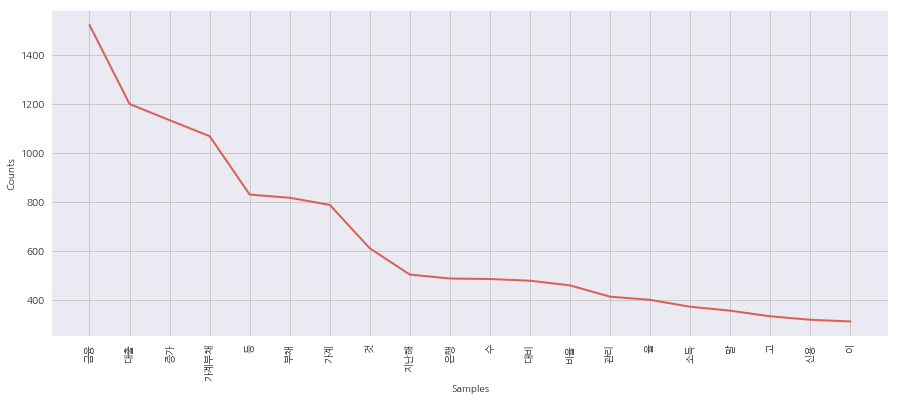

In [42]:
fig = plt.figure(figsize=(15,6))
text.plot(20)

* 입력한 키워드와 동시에 나온 토큰

In [44]:
text.concordance('가계부채')

Displaying 25 of 1068 matches:
권 대한 고지 의무 추심 및 거래 금지 채무자 대리인 제도 활성화 가계부채 문제 해결 위 금융 소비자 단체 연대 회의 취약 차주 보호 위 입
융통화위원회 정기 회의 금융 상황 점검 관련 자료 공개 해당 자료 가계부채 가계 신용 기준 증가 세 년말 대비 둔화 가계 소득 증가 율 추 
 대비 둔화 가계 소득 증가 율 추 정치 웃 처분 가능 소득 대비 가계부채 비율 무려 또한 다중 채무자 면서 소득 신용 취약 차주 부채 규모
 단축 채무자 회생 및 파산 관 법률 일부 개정 법률 안 처리 뒤 가계부채 문제 해결 위 입법 사실 손 상태 금융 소비자 연대 회의 천문학 
 채무자 대해 채무 기조 정책 계속 제시 제한 적용 그 실효 담보 가계부채 증가 율 연 내 목표 가계부채 규모 수준 위 구체 목표 수단 제시
계속 제시 제한 적용 그 실효 담보 가계부채 증가 율 연 내 목표 가계부채 규모 수준 위 구체 목표 수단 제시 가계 파탄 소비 여력 회복 관
민 풍요 워 진 국민 오히려 살기 더 의견 지배 반증 듯 우리나라 가계부채 늘 지난달 말 은 금융 안정 자료 우리나라 가계부채 현재 년말 증
 듯 우리나라 가계부채 늘 지난달 말 은 금융 안정 자료 우리나라 가계부채 현재 년말 증가 증가 이후 가장 수준 둔화 가계 소득 증가 율 웃
 부채 규모 년 대비 문재인 정부 적극 추진 두 차례 부동산 대책 가계부채 증가 율 둔화 자평 벼랑 끝 신용 영세 자영 업자 다중 채무자 취
팀목 수출 세계 경제 불안 크게 수출 감소 폭 작년 올해 로 점차 가계부채 국가채무 늘 체감 경기 악화 국민총소득 누가 돈 벌 어간 것 의문
 이유 권 진안 글로벌 코노믹 기자 연재 김종찬 안보 경제 블로그 가계부채 금융시장 정책 부산물 종속 상황 더 정부 기업 부채 증가 율 가계
부채 금융시장 정책 부산물 종속 상황 더 정부 기업 부채 증가 율 가계부채 증가 상황 가계부채 증가 억제 가계부채 가계 소득 앞서 취약 대출
부산물 종속 상황 더 정부 기업 부채 

연도별로 만들어보자 

In [48]:
df1.date.dtype

dtype('O')

In [50]:
df1['date1'] = pd.to_datetime(df1.date, utc=True)

In [52]:
df1['mm'] = df1.date1.dt.strftime('%Y%m')

In [54]:
df1[['date','date1','mm']].head()

,date,date1,mm
0,None,NaT,NaT
1,2019-04-10 10:24:50+09:00,2019-04-10 01:24:50+00:00,201904
2,2019-04-10 10:55:00+09:00,2019-04-10 01:55:00+00:00,201904
3,2019-04-10 11:12:00+09:00,2019-04-10 02:12:00+00:00,201904
4,2019-04-07 00:00:00,2019-04-07 00:00:00+00:00,201904


In [55]:
df1.mm.value_counts(dropna=False)

NaT       62
201903    56
201902    36
201904    29
201901    12
Name: mm, dtype: int64